# SetUp

In [1]:
import cv2
import torch
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

2023-02-22 12:50:50.095098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 12:50:51.500304: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/null/miniconda3/envs/neural_style_transfer/lib/python3.7/site-packages/cv2/../../lib64:
2023-02-22 12:50:51.500406: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/null/miniconda3/envs/neural_st

TF Version:  2.11.0
TF Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  []


2023-02-22 12:50:52.863362: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/null/miniconda3/envs/neural_style_transfer/lib/python3.7/site-packages/cv2/../../lib64:
2023-02-22 12:50:52.863421: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-22 12:50:52.863455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost-live.attlocal.net): /proc/driver/nvidia/version does not exist


# Images Utils

In [2]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Load the input images.
content_path = tf.keras.utils.get_file('belfry.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg')
style_path = tf.keras.utils.get_file('style23.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg')
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

2023-02-22 12:50:52.992574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


# Load some Images

Content image shape:  (1, 256, 256, 3)
Content image shape:  (1, 256, 256, 3)


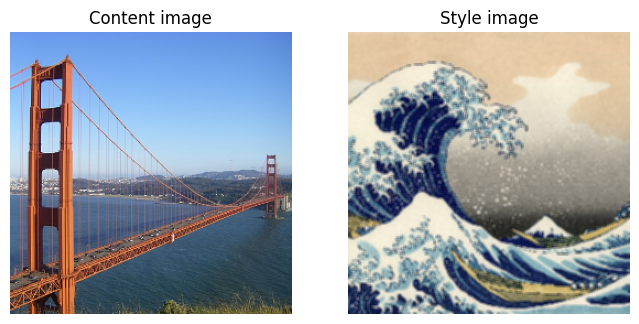

In [3]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 256  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
print('Content image shape: ', content_image.shape)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
print('Content image shape: ', content_image.shape)
show_n([content_image, style_image], ['Content image', 'Style image'])

# Load the model

In [4]:
# Load TF Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

# Define the style transfer function

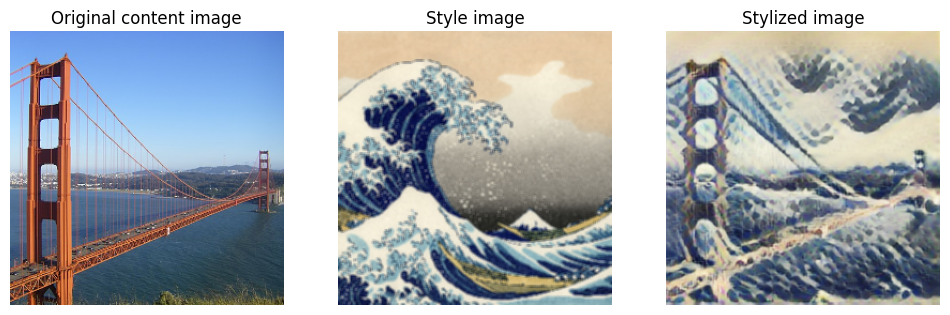

In [5]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

# Style Transform with TFLIte

## Download The Style Transform and Style Prediction TFLite Model

In [6]:
# if you are running the model on a smartphone, you can use the following code to download the model files and load them into the model.
# https://github.com/tensorflow/tensorflow/issues/21698#issuecomment-414764709
style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')
#style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
#style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')
#style_predict_path = "magenta_arbitrary-image-stylization-v1-256_fp16_prediction_1.tflite"
#style_transform_path = "magenta_arbitrary-image-stylization-v1-256_fp16_transfer_1.tflite"

## Style Predict with TFLite

In [7]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


# Style Transform with TFLIte method

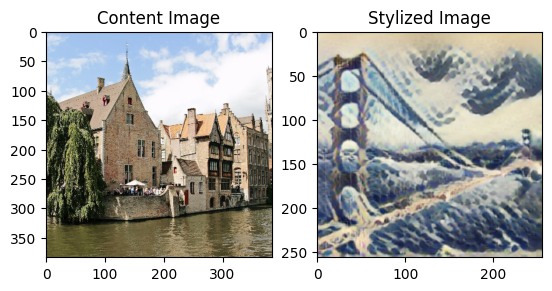

In [8]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # get model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image
def run_style_transform_without_loading_the_model(interpreter , style_bottleneck, preprocessed_content_image):

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image
# Stylize the content image using the style bottleneck.
#stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

# Set webcam UP

In [9]:
# Set webcam settings
width = 500
height = 500
cam = cv2.VideoCapture(0)
cam.set(3, width)
cam.set(4, height)

True

# TFLITE single Run

In [10]:
'''
## No more interpreter called anymore
# Load the model  The model path is then fed to the Interpreter class constructor for loading it. The loaded model is returned in the interpreter variable.
interpreter = tf.lite.Interpreter(model_path=style_transform_path)
# Set model input.
#After the model is loaded, the allocate_tensors() method is called for allocating memory for the input and output tensors.
interpreter.allocate_tensors()
infomation_about_input = interpreter.get_input_details()
'''

'\n## No more interpreter called anymore\n# Load the model  The model path is then fed to the Interpreter class constructor for loading it. The loaded model is returned in the interpreter variable.\ninterpreter = tf.lite.Interpreter(model_path=style_transform_path)\n# Set model input.\n#After the model is loaded, the allocate_tensors() method is called for allocating memory for the input and output tensors.\ninterpreter.allocate_tensors()\ninfomation_about_input = interpreter.get_input_details()\n'

# Main Loop

In [12]:
import time
# Main loop
## No more interpreter called anymore
# Load the model.
interpreter = tf.lite.Interpreter(model_path=style_transform_path)
# Set model input.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.allocate_tensors()
count = 0 
with torch.no_grad():
    while True:
        # Get webcam input
        ret_val, img = cam.read()

        # Mirror 
        img = cv2.flip(img, 1)
        print(img.shape)
        print(f"The image is {img.shape[0]} pixels high and {img.shape[1]} pixels wide")
        print(f"The image data type is {img.dtype}")
        
        # Preprocess the images
        tf_image = tf.image.convert_image_dtype(img, tf.float32)
        tf_image = tf_image[tf.newaxis, :]
        preprocess_video_image = preprocess_image(tf_image, 384)
        print(f"The shape of the preprocessed image is {preprocess_video_image.shape}")
        
        # Load the model inputs 
        start_time = time.time()
        #stylized_image = run_style_transform_without_loading_the_model( interpreter,  style_bottleneck, preprocess_video_image) 
        # Set model inputs.
        # input_details[0]['index'] = the index which accepts the input
        interpreter.set_tensor(input_details[0]["index"], preprocess_video_image)
        interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
        # run the inference
        interpreter.invoke()
        stylized_image = interpreter.get_tensor(output_details[0]["index"])
        print("Time taken: ", time.time() - start_time)
        
        ## Conver the styleized image into uint8 numpy array that can feed into cv2 video camers
        print(f"The image is {stylized_image.shape[0]} pixels high and {stylized_image.shape[1]} pixels wide")
        print(f"The image daa type is {stylized_image.dtype}")
        # Display result
        cv2.imshow('my webcam',  stylized_image[0])
        if cv2.waitKey(1) == 27: 
            break # esc to quit
# Free-up memories
cam.release()
cv2.destroyAllWindows()
        
        
        
        
    

(480, 640, 3)
The image is 480 pixels high and 640 pixels wide
The image data type is uint8
The shape of the preprocessed image is (1, 256, 256, 3)


ValueError: Cannot set tensor: Dimension mismatch. Got 256 but expected 384 for dimension 1 of input 0.